# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [1]:
from usl_models.flood_ml.dataset import  load_dataset_windowed_cached

import tensorflow as tf
import keras_tuner
import time
from datetime import datetime
import keras
import logging
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.dataset import load_dataset_windowed
import pathlib
# === CONFIG ===
# Set random seeds and GPU memory growth
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/training_{timestamp}"

2026-01-28 21:23:26.316039: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 21:23:26.366991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-28 21:23:26.367023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-28 21:23:26.368377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-28 21:23:26.376439: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# for fatser loading during hyperparameter tuning use this function
def get_datasets(batch_size=2):
    filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
    city_config_mapping = {"Manhattan": "Manhattan_config"}
    # rainfall_files = [7, 5, 13, 11, 9, 16, 15, 10, 12, 2, 3]
    rainfall_files = [7,5,16,15]  # Only 5 and 6
    m_rainfall = 6
    n_flood_maps = 5

    sim_names = []
    for city, config in city_config_mapping.items():
        for rain_id in rainfall_files:
            sim_names.append(f"{city}-{config}/Rainfall_Data_{rain_id}.txt")
    print("Sim names in use:")
    for s in sim_names:
        print("  ", s, (filecache_dir / s).exists())

    train_ds = load_dataset_windowed_cached(
        filecache_dir=filecache_dir,
        sim_names=sim_names,
        dataset_split="train",
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
        shuffle=True,
    )

    val_ds = load_dataset_windowed_cached(
        filecache_dir=filecache_dir,
        sim_names=sim_names,
        dataset_split="val",
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
        shuffle=True,
    )

    return train_ds, val_ds

In [ ]:
import gc

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
        unroll_steps=[1, 2],   # start small (1 = no rollout, 2 = short rollout)
    ),
    objective="val_loss",
    max_trials=2,  # increase if you want more search
    project_name=log_dir,
)

tb_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    profile_batch=0,
)

def tuner_search(batch_size=2, num_train_samples=200, num_val_samples=100):
    """
    Run Bayesian optimization tuner on a limited number of *samples*.
    Automatically computes how many batches are needed based on batch_size.
    """
    # Clear memory and TensorFlow graph
    gc.collect()
    tf.keras.backend.clear_session()

    # Get datasets
    train_ds, val_ds = get_datasets(batch_size=batch_size)

    # Convert sample counts → batch counts
    num_train_batches = max(1, num_train_samples // batch_size)
    num_val_batches = max(1, num_val_samples // batch_size)

    print(f"Using {num_train_batches} train batches "
          f"({num_train_batches * batch_size} samples)")
    print(f"Using {num_val_batches} validation batches "
          f"({num_val_batches * batch_size} samples)")

    # Run tuner
    tuner.search(
        train_ds.take(num_train_batches),
        validation_data=val_ds.take(num_val_batches),
        epochs=2,
        callbacks=[tb_callback],
        verbose=1,
    )

# Enable GPU operation logging (optional)
tf.debugging.set_log_device_placement(True)

# Run tuner
tuner_search(batch_size=2, num_train_samples=200, num_val_samples=50)

# Retrieve best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
print("Best hyperparameters:", best_hp.values)


In [ ]:
# %%
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_ds, val_ds = get_datasets(batch_size=2)
# Define final parameters and model
final_params_dict = best_hp.values.copy()
final_params = FloodModel.Params(**final_params_dict)
model = FloodModel(params=final_params)
# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf",
    ),
    EarlyStopping(  # <--- ADD THIS
        monitor="val_loss",  # What to monitor
        patience=100,  # Number of epochs with no improvement to wait
        restore_best_weights=True,  # Restore model weights from best epoch
        mode="min",  # "min" because lower val_loss is better
    ),
]
tf.debugging.set_log_device_placement(True)
# Train
model.fit(train_ds, val_ds, epochs=1, callbacks=callbacks)

# Save final model
model.save_model(log_dir + "/model")

In [ ]:
# Now create two time steps autoregressive model for testing using two time steps inputs

In [3]:
def make_k_step_gt_batch_safe(ds, batch_size, k_steps=4):
    """
    Converts:
        (x_t, y_t) → (x_t, [y_t, y_{t+1}, ..., y_{t+k-1}])

    Output label shape:
        (B, k_steps, H, W)
    """

    # 1. Unbatch to single examples
    ds = ds.unbatch()

    # 2. Window consecutive timesteps of length k_steps
    ds = ds.window(k_steps, shift=1, drop_remainder=True)

    # 3. Batch each tensor field inside each window
    def batch_window(x_win, y_win):
        x_seq = {key: tensor.batch(k_steps)
                 for key, tensor in x_win.items()}
        y_seq = y_win.batch(k_steps)
        return tf.data.Dataset.zip((x_seq, y_seq))

    ds = ds.flat_map(batch_window)

    # 4. Pack input = first step, GT = full sequence
    def pack_k_steps(x_seq, y_seq):
        # Input stays at time t
        x_t = {key: tensor[0] for key, tensor in x_seq.items()}

        # Label sequence is length k_steps
        gt_seq = y_seq

        return x_t, gt_seq

    ds = ds.map(pack_k_steps, num_parallel_calls=tf.data.AUTOTUNE)

    # 5. Rebatch for training
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


In [5]:
train_ds, val_ds = get_datasets(batch_size=2)
train_2 = make_two_step_gt_batch_safe(train_ds, batch_size=2)

print("element_spec:", train_2.element_spec)

x2, gt2 = next(iter(train_2.take(1)))
print("GT shape:", gt2.shape)
print("geospatial:", x2["geospatial"].shape)
print("temporal:", x2["temporal"].shape)
print("spatiotemporal:", x2["spatiotemporal"].shape)


Sim names in use:
   Manhattan-Manhattan_config/Rainfall_Data_7.txt True
   Manhattan-Manhattan_config/Rainfall_Data_5.txt True
   Manhattan-Manhattan_config/Rainfall_Data_16.txt True
   Manhattan-Manhattan_config/Rainfall_Data_15.txt True


2026-01-26 17:51:36.069038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


element_spec: ({'geospatial': TensorSpec(shape=(2, 1000, 1000, 9), dtype=tf.float32, name=None), 'temporal': TensorSpec(shape=(2, 5, 6), dtype=tf.float32, name=None), 'spatiotemporal': TensorSpec(shape=(2, 5, 1000, 1000, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(2, None, 1000, 1000), dtype=tf.float32, name=None))
GT shape: (2, 2, 1000, 1000)
geospatial: (2, 1000, 1000, 9)
temporal: (2, 5, 6)
spatiotemporal: (2, 5, 1000, 1000, 1)


In [6]:
train_ds, val_ds = get_datasets(batch_size=2)

train_2 = make_two_step_gt_batch_safe(train_ds, batch_size=2)
val_2   = make_two_step_gt_batch_safe(val_ds, batch_size=2)


Sim names in use:
   Manhattan-Manhattan_config/Rainfall_Data_7.txt True
   Manhattan-Manhattan_config/Rainfall_Data_5.txt True
   Manhattan-Manhattan_config/Rainfall_Data_16.txt True
   Manhattan-Manhattan_config/Rainfall_Data_15.txt True


In [7]:
def use_first_gt_only(ds):
    """
    Converts (x, [y_t1, y_t2]) → (x, y_t1)
    Keeps the model API unchanged.
    """
    return ds.map(
        lambda x, y: (x, y[:, 0]),
        num_parallel_calls=tf.data.AUTOTUNE,
    )


In [8]:
train_ds_final = use_first_gt_only(train_2)
val_ds_final   = use_first_gt_only(val_2)


In [9]:
def ensure_channel_dim(ds):
    return ds.map(
        lambda x, y: (x, tf.expand_dims(y, axis=-1)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )


In [ ]:
train_ds_final = ensure_channel_dim(train_ds_final)
val_ds_final   = ensure_channel_dim(val_ds_final)
print("Final dataset element spec:", train_ds_final.element_spec)

Final dataset element spec: ({'geospatial': TensorSpec(shape=(2, 1000, 1000, 9), dtype=tf.float32, name=None), 'temporal': TensorSpec(shape=(2, 5, 6), dtype=tf.float32, name=None), 'spatiotemporal': TensorSpec(shape=(2, 5, 1000, 1000, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(2, 1000, 1000, 1), dtype=tf.float32, name=None))


In [12]:
import gc

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
        unroll_steps=[1, 2],   # start small (1 = no rollout, 2 = short rollout)
    ),
    objective="val_loss",
    max_trials=10,  # increase if you want more search
    project_name=log_dir,
)

tb_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    profile_batch=0,
)

def tuner_search(batch_size=2, num_train_samples=200, num_val_samples=100):
    """
    Run Bayesian optimization tuner on a limited number of *samples*.
    Automatically computes how many batches are needed based on batch_size.
    """
    # Clear memory and TensorFlow graph
    gc.collect()
    tf.keras.backend.clear_session()

    # Get datasets
    train_ds, val_ds = get_datasets(batch_size=batch_size)

    # Convert sample counts → batch counts
    num_train_batches = max(1, num_train_samples // batch_size)
    num_val_batches = max(1, num_val_samples // batch_size)

    print(f"Using {num_train_batches} train batches "
          f"({num_train_batches * batch_size} samples)")
    print(f"Using {num_val_batches} validation batches "
          f"({num_val_batches * batch_size} samples)")

    # Run tuner
    tuner.search(
        train_ds_final.take(num_train_batches),
        validation_data=val_ds_final.take(num_val_batches),
        epochs=10,
        callbacks=[tb_callback],
        verbose=1,
    )

# Enable GPU operation logging (optional)
tf.debugging.set_log_device_placement(True)

# Run tuner
tuner_search(batch_size=2, num_train_samples=200, num_val_samples=50)

# Retrieve best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
print("Best hyperparameters:", best_hp.values)


Trial 10 Complete [00h 04m 39s]
val_loss: 0.03165352717041969

Best val_loss So Far: 0.019884301349520683
Total elapsed time: 00h 39m 03s
Best hyperparameters: {'lstm_units': 128, 'lstm_kernel_size': 3, 'lstm_dropout': 0.2, 'lstm_recurrent_dropout': 0.2, 'n_flood_maps': 5, 'm_rainfall': 6, 'unroll_steps': 1}


In [13]:
# %%
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define final parameters and model
final_params_dict = best_hp.values.copy()
final_params = FloodModel.Params(**final_params_dict)
model = FloodModel(params=final_params)
# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf",
    ),
    EarlyStopping(  # <--- ADD THIS
        monitor="val_loss",  # What to monitor
        patience=100,  # Number of epochs with no improvement to wait
        restore_best_weights=True,  # Restore model weights from best epoch
        mode="min",  # "min" because lower val_loss is better
    ),
]
tf.debugging.set_log_device_placement(True)
# Train
model.fit(train_ds_final, val_ds_final, epochs=20, callbacks=callbacks)

# Save final model
model.save_model(log_dir + "/model")

Epoch 1/20
    443/Unknown - 86s 182ms/step - loss: 0.0210 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0881

2026-01-26 18:59:09.069971: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3014536341849054192
2026-01-26 18:59:09.070029: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7304253933719641570


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 98s 207ms/step - loss: 0.1831 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0881 - val_loss: 0.1222 - val_mean_absolute_error: 0.0197 - val_root_mean_squared_error: 0.0734
Epoch 2/20
443/443 [==============================] - ETA: 0s - loss: 0.0927 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0657INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 208ms/step - loss: 0.0951 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0657 - val_loss: 0.0850 - val_mean_absolute_error: 0.0177 - val_root_mean_squared_error: 0.0615
Epoch 3/20
443/443 [==============================] - ETA: 0s - loss: 0.0481 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0571INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 206ms/step - loss: 0.0714 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0571 - val_loss: 0.0703 - val_mean_absolute_error: 0.0159 - val_root_mean_squared_error: 0.0558
Epoch 4/20
443/443 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0514INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 207ms/step - loss: 0.0576 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0514 - val_loss: 0.0645 - val_mean_absolute_error: 0.0155 - val_root_mean_squared_error: 0.0541
Epoch 5/20
443/443 [==============================] - ETA: 0s - loss: 0.1311 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0489INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 93s 208ms/step - loss: 0.0522 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0489 - val_loss: 0.0617 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0506
Epoch 6/20
443/443 [==============================] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0459INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 206ms/step - loss: 0.0460 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0459 - val_loss: 0.0572 - val_mean_absolute_error: 0.0156 - val_root_mean_squared_error: 0.0519
Epoch 7/20
443/443 [==============================] - ETA: 0s - loss: 0.0593 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0439INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 207ms/step - loss: 0.0421 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0439 - val_loss: 0.0486 - val_mean_absolute_error: 0.0137 - val_root_mean_squared_error: 0.0467
Epoch 8/20
443/443 [==============================] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0425INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 93s 208ms/step - loss: 0.0396 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0425 - val_loss: 0.0474 - val_mean_absolute_error: 0.0137 - val_root_mean_squared_error: 0.0454
Epoch 9/20
443/443 [==============================] - 88s 197ms/step - loss: 0.0371 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0412 - val_loss: 0.0493 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0468
Epoch 10/20
443/443 [==============================] - ETA: 0s - loss: 0.0233 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0399INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 206ms/step - loss: 0.0348 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0399 - val_loss: 0.0447 - val_mean_absolute_error: 0.0139 - val_root_mean_squared_error: 0.0457
Epoch 11/20
443/443 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0397INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 207ms/step - loss: 0.0346 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0397 - val_loss: 0.0417 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0430
Epoch 12/20
443/443 [==============================] - 88s 197ms/step - loss: 0.0318 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0381 - val_loss: 0.0432 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0433
Epoch 13/20
443/443 [==============================] - 88s 198ms/step - loss: 0.0305 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0373 - val_loss: 0.0431 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0439
Epoch 14/20
443/443 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0369INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framew

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 208ms/step - loss: 0.0299 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0369 - val_loss: 0.0414 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0426
Epoch 15/20
443/443 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0372INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 93s 209ms/step - loss: 0.0306 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0372 - val_loss: 0.0409 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0425
Epoch 16/20
443/443 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0357INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 206ms/step - loss: 0.0280 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0357 - val_loss: 0.0396 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0422
Epoch 17/20
443/443 [==============================] - 88s 198ms/step - loss: 0.0274 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0353 - val_loss: 0.0397 - val_mean_absolute_error: 0.0119 - val_root_mean_squared_error: 0.0409
Epoch 18/20
443/443 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0352INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 92s 207ms/step - loss: 0.0273 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0352 - val_loss: 0.0380 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0408
Epoch 19/20
443/443 [==============================] - 88s 197ms/step - loss: 0.0272 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0351 - val_loss: 0.0389 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0411
Epoch 20/20
443/443 [==============================] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0344INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/checkpoint/assets


443/443 [==============================] - 93s 209ms/step - loss: 0.0260 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0344 - val_loss: 0.0372 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0407
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6751fad0>, 139622533346256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6752ea10>, 139622533346592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6756a710>, 139622534008480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc6757d850>, 139622534008816), {}).


INFO:tensorflow:Assets written to: logs/training_20260126-175054/model/assets


INFO:tensorflow:Assets written to: logs/training_20260126-175054/model/assets


In [3]:
def pad_temporal_to_tmax(x, tmax):
    """
    Pads temporal input from (B, n, M) → (B, T_MAX, M)
    """
    temporal = x["temporal"]
    B, n, M = temporal.shape

    pad_len = tmax - n
    if pad_len < 0:
        raise ValueError("Temporal window larger than T_MAX")

    pad = tf.zeros((B, pad_len, M), dtype=temporal.dtype)
    temporal_full = tf.concat([temporal, pad], axis=1)

    x_full = dict(x)
    x_full["temporal"] = temporal_full
    return x_full


In [4]:
from usl_models.flood_ml import constants
T_MAX = constants.MAX_RAINFALL_DURATION


In [19]:
# Take one batch from the 2-step dataset
x, gt = next(iter(val_2.take(1)))

# Ground truth
gt_t1 = gt[:, 0]   # (B, H, W)
gt_t2 = gt[:, 1]

# ---- t+1 prediction (teacher-forced) ----
pred_t1 = model.call(x)[..., 0]  # (B, H, W)

# ---- t+2 prediction (autoregressive rollout) ----
x_full = pad_temporal_to_tmax(x, T_MAX)
pred_rollout = model.call_n(x_full, n=2)  # (B, 2, H, W)
pred_t2 = pred_rollout[:, 1]

# Metrics
print("t+1 MAE:", tf.reduce_mean(tf.abs(pred_t1 - gt_t1)))
print("t+2 MAE:", tf.reduce_mean(tf.abs(pred_t2 - gt_t2)))


t+1 MAE: tf.Tensor(0.02165979, shape=(), dtype=float32)
t+2 MAE: tf.Tensor(0.029615164, shape=(), dtype=float32)


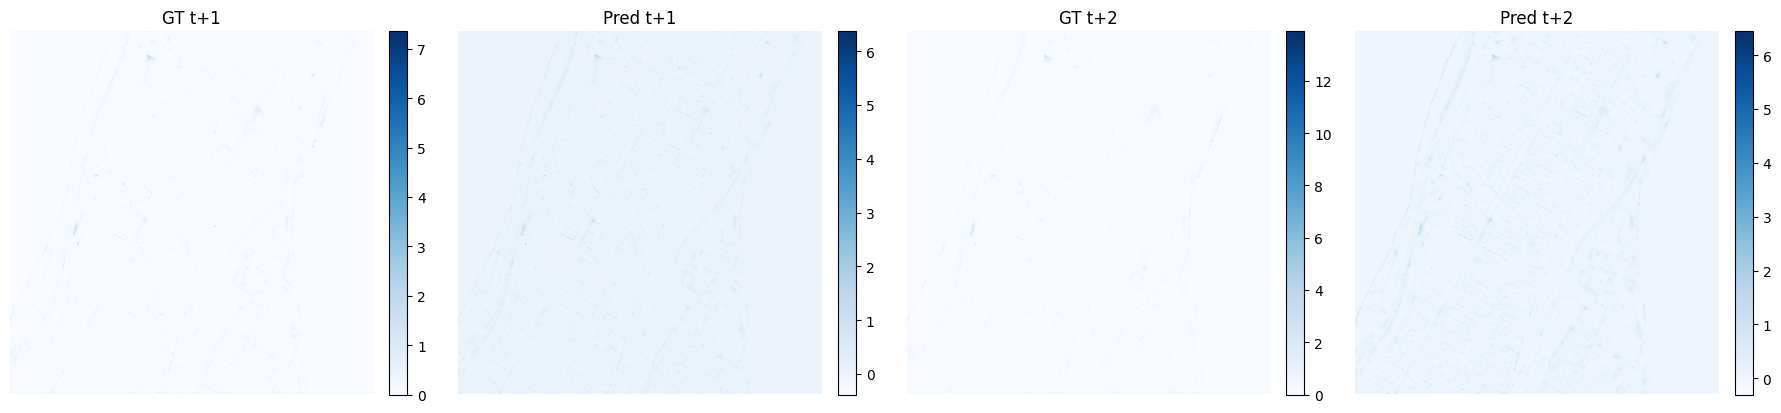

In [22]:
import matplotlib.pyplot as plt

# Pick sample
i = 0

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

im0 = axs[0].imshow(gt_t1[i], cmap="Blues")
axs[0].set_title("GT t+1")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(pred_t1[i], cmap="Blues")
axs[1].set_title("Pred t+1")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(gt_t2[i], cmap="Blues")
axs[2].set_title("GT t+2")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

im3 = axs[3].imshow(pred_t2[i], cmap="Blues")
axs[3].set_title("Pred t+2")
fig.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


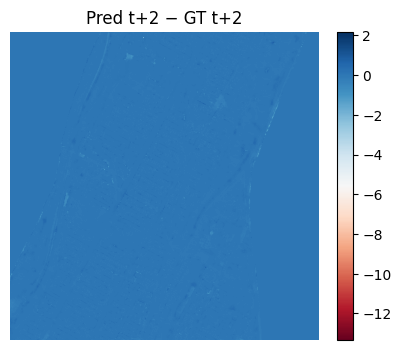

In [21]:
plt.figure(figsize=(5,4))
plt.imshow(pred_t2[i] - gt_t2[i], cmap="RdBu")
plt.colorbar()
plt.title("Pred t+2 − GT t+2")
plt.axis("off")
plt.show()


In [23]:
import tensorflow as tf
import numpy as np
from usl_models.flood_ml import constants

T_MAX = constants.MAX_RAINFALL_DURATION

def pad_temporal_to_tmax(x, tmax=T_MAX):
    temporal = x["temporal"]
    B = tf.shape(temporal)[0]
    n = tf.shape(temporal)[1]
    M = tf.shape(temporal)[2]
    pad_len = tmax - n
    temporal_full = tf.concat([temporal, tf.zeros((B, pad_len, M), temporal.dtype)], axis=1)
    x2 = dict(x)
    x2["temporal"] = temporal_full
    return x2

def eval_t1_t2(model, ds_two_step, num_batches=50):
    maes_t1, maes_t2 = [], []
    bias_t2 = []
    peak_ratio_t2 = []  # max(pred)/max(gt) per sample

    for x, gt in ds_two_step.take(num_batches):
        gt_t1 = gt[:, 0]
        gt_t2 = gt[:, 1]

        pred_t1 = model.call(x)[..., 0]
        pred_roll = model.call_n(pad_temporal_to_tmax(x), n=2)
        pred_t2 = pred_roll[:, 1]

        maes_t1.append(tf.reduce_mean(tf.abs(pred_t1 - gt_t1)).numpy())
        maes_t2.append(tf.reduce_mean(tf.abs(pred_t2 - gt_t2)).numpy())

        bias_t2.append(tf.reduce_mean(pred_t2 - gt_t2).numpy())

        # peak ratio across batch (avoid divide-by-zero)
        gt_max = tf.reduce_max(gt_t2, axis=[1,2])
        pr_max = tf.reduce_max(pred_t2, axis=[1,2])
        ratio = pr_max / tf.maximum(gt_max, 1e-6)
        peak_ratio_t2.append(tf.reduce_mean(ratio).numpy())

    print("MAE t+1 mean:", float(np.mean(maes_t1)), "std:", float(np.std(maes_t1)))
    print("MAE t+2 mean:", float(np.mean(maes_t2)), "std:", float(np.std(maes_t2)))
    print("Bias t+2 mean (pred-gt):", float(np.mean(bias_t2)))
    print("Peak ratio t+2 mean max(pred)/max(gt):", float(np.mean(peak_ratio_t2)))

# Example:
# val_2 = make_two_step_gt_batch_safe(val_ds, batch_size=2)
eval_t1_t2(model, val_2, num_batches=50)


MAE t+1 mean: 0.01197953149676323 std: 0.008173175156116486
MAE t+2 mean: 0.015157375484704971 std: 0.009651432745158672
Bias t+2 mean (pred-gt): 0.003413650207221508
Peak ratio t+2 mean max(pred)/max(gt): 1.1088416576385498


In [ ]:
# New test with rollout

In [4]:
train_ds, val_ds = get_datasets(batch_size=2)
train_2 = make_k_step_gt_batch_safe(train_ds, batch_size=2, k_steps=3)
val_2   = make_k_step_gt_batch_safe(val_ds, batch_size=2, k_steps=3)


Sim names in use:
   Manhattan-Manhattan_config/Rainfall_Data_7.txt True
   Manhattan-Manhattan_config/Rainfall_Data_5.txt True
   Manhattan-Manhattan_config/Rainfall_Data_16.txt True
   Manhattan-Manhattan_config/Rainfall_Data_15.txt True


2026-01-28 21:23:50.649103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [5]:
train_ds_final = train_2
val_ds_final   = val_2


In [6]:
print(train_ds_final.element_spec)


({'geospatial': TensorSpec(shape=(2, 1000, 1000, 9), dtype=tf.float32, name=None), 'temporal': TensorSpec(shape=(2, 5, 6), dtype=tf.float32, name=None), 'spatiotemporal': TensorSpec(shape=(2, 5, 1000, 1000, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(2, None, 1000, 1000), dtype=tf.float32, name=None))


In [7]:
import gc

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[128],
        lstm_kernel_size=[5],
        lstm_dropout=[0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
    objective="val_loss",
    max_trials=10,  # increase if you want more search
    project_name=log_dir,
)

tb_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    profile_batch=0,
)

def tuner_search(batch_size=2, num_train_samples=200, num_val_samples=100):
    """
    Run Bayesian optimization tuner on a limited number of *samples*.
    Automatically computes how many batches are needed based on batch_size.
    """
    # Clear memory and TensorFlow graph
    gc.collect()
    tf.keras.backend.clear_session()

    # Get datasets
    train_ds, val_ds = get_datasets(batch_size=batch_size)

    # Convert sample counts → batch counts
    num_train_batches = max(1, num_train_samples // batch_size)
    num_val_batches = max(1, num_val_samples // batch_size)

    print(f"Using {num_train_batches} train batches "
          f"({num_train_batches * batch_size} samples)")
    print(f"Using {num_val_batches} validation batches "
          f"({num_val_batches * batch_size} samples)")

    # Run tuner
    tuner.search(
        train_ds_final.take(num_train_batches),
        validation_data=val_ds_final.take(num_val_batches),
        epochs=10,
        callbacks=[tb_callback],
        verbose=1,
    )

# Enable GPU operation logging (optional)
tf.debugging.set_log_device_placement(True)

# Run tuner
tuner_search(batch_size=2, num_train_samples=200, num_val_samples=50)

# Retrieve best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
print("Best hyperparameters:", best_hp.values)


Trial 2 Complete [00h 12m 37s]
val_loss: 0.07486141473054886

Best val_loss So Far: 0.05118486285209656
Total elapsed time: 00h 25m 26s
Best hyperparameters: {'lstm_units': 128, 'lstm_kernel_size': 5, 'lstm_dropout': 0.3, 'lstm_recurrent_dropout': 0.3, 'n_flood_maps': 5, 'm_rainfall': 6}


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Build model from best hyperparameters
final_params_dict = best_hp.values.copy()
final_params = FloodModel.Params(**final_params_dict)
model = FloodModel(params=final_params)

callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf",
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=100,
        restore_best_weights=True,
        mode="min",
    ),
]

# ✅ IMPORTANT: use multi-step datasets
model.fit(
    train_ds_final,
    val_ds_final,
    epochs=10,
    callbacks=callbacks,
)

model.save_model(log_dir + "/model")


Epoch 1/10
    443/Unknown - 313s 686ms/step - loss: 0.0770 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0977

2026-01-28 22:00:17.208236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2675251775702388587
2026-01-28 22:00:17.208294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11175265391515521602


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 333s 732ms/step - loss: 0.2498 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0977 - val_loss: 0.2138 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0884
Epoch 2/10
443/443 [==============================] - ETA: 0s - loss: 0.1470 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0825INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 730ms/step - loss: 0.1757 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0825 - val_loss: 0.1771 - val_mean_absolute_error: 0.0237 - val_root_mean_squared_error: 0.0764
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.0952 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0743INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 323s 730ms/step - loss: 0.1435 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0743 - val_loss: 0.1589 - val_mean_absolute_error: 0.0230 - val_root_mean_squared_error: 0.0725
Epoch 4/10
443/443 [==============================] - ETA: 0s - loss: 0.3092 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0703INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 731ms/step - loss: 0.1310 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0703 - val_loss: 0.1371 - val_mean_absolute_error: 0.0246 - val_root_mean_squared_error: 0.0678
Epoch 5/10
443/443 [==============================] - ETA: 0s - loss: 0.4172 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0659INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 730ms/step - loss: 0.1174 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0659 - val_loss: 0.1294 - val_mean_absolute_error: 0.0199 - val_root_mean_squared_error: 0.0646
Epoch 6/10
443/443 [==============================] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0640INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 730ms/step - loss: 0.1132 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0640 - val_loss: 0.1282 - val_mean_absolute_error: 0.0196 - val_root_mean_squared_error: 0.0644
Epoch 7/10
443/443 [==============================] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0612INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 731ms/step - loss: 0.1051 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0612 - val_loss: 0.1233 - val_mean_absolute_error: 0.0254 - val_root_mean_squared_error: 0.0706
Epoch 8/10
443/443 [==============================] - ETA: 0s - loss: 0.2452 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0608INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132aa050>, 140132225852208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132c0ed0>, 140132225843888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 7, 2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f73132fc9d0>, 140132224457136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7313103990>, 140132225845040), {}).


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


INFO:tensorflow:Assets written to: logs/training_20260128-212328/checkpoint/assets


443/443 [==============================] - 324s 731ms/step - loss: 0.1051 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0608 - val_loss: 0.1167 - val_mean_absolute_error: 0.0217 - val_root_mean_squared_error: 0.0598
Epoch 9/10
114/443 [======>.......................] - ETA: 3:46 - loss: 0.0231 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0488

KeyboardInterrupt: 

In [9]:
x, y = next(iter(val_ds_final.take(1)))

print("spatiotemporal:", x["spatiotemporal"].shape)
print("temporal:", x["temporal"].shape)
print("geospatial:", x["geospatial"].shape)
print("GT:", y.shape)


spatiotemporal: (2, 5, 1000, 1000, 1)
temporal: (2, 5, 6)
geospatial: (2, 1000, 1000, 9)
GT: (2, 2, 1000, 1000)


In [14]:
import numpy as np
from usl_models.flood_ml import constants

T_MAX = constants.MAX_RAINFALL_DURATION

def pad_temporal_to_tmax(x, tmax=T_MAX):
    temporal = x["temporal"]
    B = tf.shape(temporal)[0]
    n = tf.shape(temporal)[1]
    M = tf.shape(temporal)[2]
    pad_len = tmax - n
    temporal_full = tf.concat([temporal, tf.zeros((B, pad_len, M), temporal.dtype)], axis=1)
    x2 = dict(x)
    x2["temporal"] = temporal_full
    return x2

In [18]:
x, y = next(iter(val_ds_final.take(1)))

x_full = pad_temporal_to_tmax(x)

pred_call = model.call(x)
pred_call_n = model.call_n(x_full, n=1)[:, 0]

print(
    "Mean abs diff:",
    tf.reduce_mean(tf.abs(pred_call[..., 0] - pred_call_n))
)


Mean abs diff: tf.Tensor(8.209702e-06, shape=(), dtype=float32)


In [ ]:
def rollout_metrics(model, ds, n_steps=5, n_batches=20):
    maes = [[] for _ in range(n_steps)]
    biases = [[] for _ in range(n_steps)]
    peak_ratios = [[] for _ in range(n_steps)]

    for x, y in ds.take(n_batches):
        x_full = pad_temporal_to_tmax(x)
        preds = model.call_n(x_full, n=n_steps)  # (B, n, H, W)

        K = y.shape[1]  # number of GT steps available
        T = min(n_steps, K)

        for t in range(T):
            gt = y[:, t]
            pred = preds[:, t]

            maes[t].append(tf.reduce_mean(tf.abs(pred - gt)))
            biases[t].append(tf.reduce_mean(pred - gt))
            peak_ratios[t].append(
                tf.reduce_max(pred) / tf.reduce_max(gt)
            )

    return (
        [tf.reduce_mean(m).numpy() if m else None for m in maes],
        [tf.reduce_mean(b).numpy() if b else None for b in biases],
        [tf.reduce_mean(p).numpy() if p else None for p in peak_ratios],
    )


In [25]:
mae, bias, peak = rollout_metrics(model, val_ds_final, n_steps=5)


In [26]:
mae

[0.011868553, 0.01512363, None, None, None]

In [27]:
bias

[0.0042315884, 0.005317389, None, None, None]

In [28]:
peak

[0.9377281, 0.9560534, None, None, None]

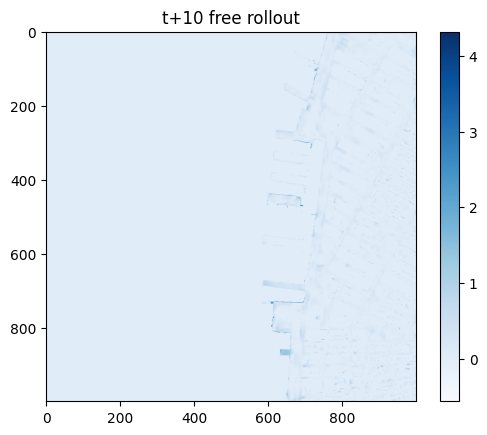

In [30]:
from matplotlib import pyplot as plt
preds = model.call_n(x_full, n=10)

plt.imshow(preds[0, -1], cmap="Blues")
plt.title("t+10 free rollout")
plt.colorbar()
plt.show()


In [32]:
# --- Sanity check: call vs call_n ---
x, y = next(iter(val_ds_final.take(1)))
x_full = pad_temporal_to_tmax(x)
pred_call = model.call(x)                    # (B, H, W, 1)
pred_call_n = model.call_n(x_full, n=1)[:, 0]     # (B, H, W)

diff = tf.reduce_mean(tf.abs(pred_call[..., 0] - pred_call_n))
print("Mean abs diff (call vs call_n):", diff.numpy())


Mean abs diff (call vs call_n): 1.1222073e-05


In [35]:
def compare_teacher_forced_vs_free(model, ds, n_batches=10):
    mae_tf = []
    mae_fr = []

    for x, y in ds.take(n_batches):
        # y: (B, 2, H, W)

        # --- teacher-forced t+2 ---
        pred_t1 = model.call(x)[..., 0]
        gt_t1 = y[:, 0]

        x_tf = {
            "geospatial": x["geospatial"],
            "temporal": x["temporal"],  # FULL
            "spatiotemporal": tf.concat(
                [x["spatiotemporal"], gt_t1[:, None, ..., None]], axis=1
            )[:, 1:],
        }

        pred_tf_t2 = model.call(x_tf)[..., 0]

        # --- free rollout t+2 ---
        preds_fr = model.call_n(x, n=2)
        pred_fr_t2 = preds_fr[:, 1]

        gt_t2 = y[:, 1]

        mae_tf.append(tf.reduce_mean(tf.abs(pred_tf_t2 - gt_t2)))
        mae_fr.append(tf.reduce_mean(tf.abs(pred_fr_t2 - gt_t2)))

    print("Teacher-forced t+2 MAE:", tf.reduce_mean(mae_tf).numpy())
    print("Free-rollout  t+2 MAE:", tf.reduce_mean(mae_fr).numpy())


In [36]:
compare_teacher_forced_vs_free(model, val_ds_final)


InvalidArgumentError: {{function_node __wrapped__EnsureShape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shape of tensor input [2,5,6] is not compatible with expected shape [2,864,6]. [Op:EnsureShape] name: 